The goal of this notebook is to code a decision tree classifier that can be used with the following API.

# Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

# Load and Prepare Data

#### Format of the data
- last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [2]:
df = pd.read_csv("../data/read.csv")
#df = df.drop("Id", axis=1)
df = df.rename(columns={"class": "label"})

In [3]:
df.head()

,fLength,fWidth,fM3Trans,fDist,label
0,28.7967,16.0021,-8.2027,81.8828,g
1,31.6036,11.7235,-9.9574,205.2610,g
2,162.0520,136.0310,-45.2160,256.7880,g
3,23.8172,9.5728,-7.1513,116.7370,g
4,75.1362,30.9205,21.8393,356.4620,g


# Train-Test-Split

In [4]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [5]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=6000)
test_df.head()

,fLength,fWidth,fM3Trans,fDist,label
12623,36.7090,8.9501,-17.0833,252.0723,h
13781,22.3630,11.6285,6.6890,148.6780,h
1326,31.0616,11.0944,7.4413,123.1100,g
8484,34.6655,12.5733,12.4028,205.6130,g
16753,11.9727,9.3311,-12.6611,272.8939,h


# Helper Functions

In [6]:
data = train_df.values
data[:5]
#numpy 2d array is faster than pandas

array([[28.7967, 16.0021, -8.2027, 81.8828, 'g'],
       [31.6036, 11.7235, -9.9574, 205.261, 'g'],
       [23.8172, 9.5728, -7.1513, 116.73700000000001, 'g'],
       [75.1362, 30.9205, 21.8393, 356.462, 'g'],
       [51.623999999999995, 21.1502, 9.8145, 238.09799999999998, 'g']],
      dtype=object)

### Data pure?

In [10]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False
check_purity(train_df[(train_df.fLength)>114.00].values) 
#true means pass in 1 class only

False

### Classify

In [11]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

### Potential splits?

/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


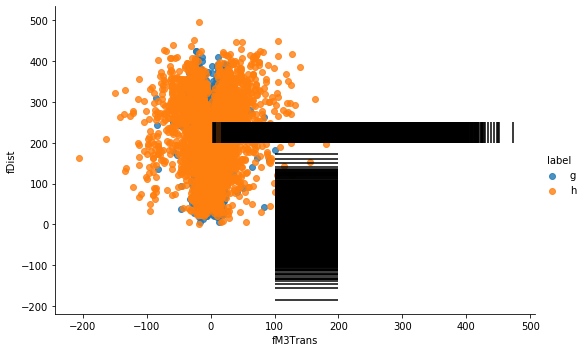

In [12]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):        # excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits
potential_splits=get_potential_splits(train_df.values)
#get_potential_splits(train_df.values)
#plot scatter plot for potential splits with seaborne
#sns.lmplot(data=train_df, x="fLength", y="fM3Trans", hue="label", fit_reg=False, size=6, aspect=1.5)
##plt.vlines(x=potential_splits[3], ymin=0, ymax=50)
#plt.hlines(y=potential_splits[2], xmin=150, xmax=200)

#sns.lmplot(data=train_df, x="fWidth", y="fM3Trans", hue="label", fit_reg=False, size=6, aspect=1.5)
##plt.vlines(x=potential_splits[3], ymin=0, ymax=9.208)
#plt.hlines(y=potential_splits[2], xmin=9.00, xmax=18.00)

#BELOW USE
sns.lmplot(data=train_df, x="fM3Trans", y="fDist", hue="label", fit_reg=False, size=5, aspect=1.5)
plt.vlines(x=potential_splits[3], ymin=200, ymax=250)
plt.hlines(y=potential_splits[2], xmin=100, xmax=200)

### Split Data

(100, 200)

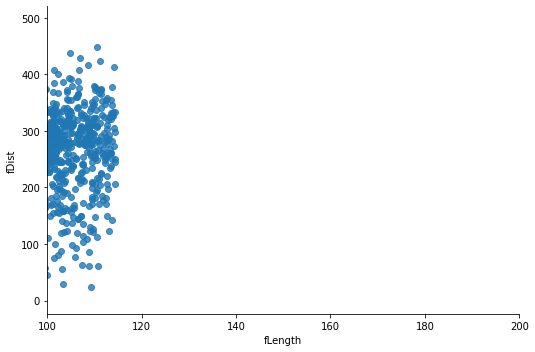

In [13]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above
split_column=0   #2 determined from function determine_best_split below
split_value=114.5064    #140
data_below, data_above=split_data(data, split_column, split_value)
plotting_df=pd.DataFrame(data_below, columns=df.columns) #data, data_above, data_below
sns.lmplot(data=plotting_df, x='fLength', y='fDist', fit_reg=False, aspect=1.5)
plt.xlim(100, 200)
#only got class g in this graph

### Lowest Overall Entropy?

In [14]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [15]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy
calculate_overall_entropy(data_below, data_above)

0.8440942971895423

In [16]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value
determine_best_split(data, potential_splits)
#take 10min to generate*

(0, 114.5064)

# Decision Tree Algorithm

### Representation of the Decision Tree

In [ ]:
'''{'fLength <= 114.5064': [{'fWidth <= 10.3329': [{'fLength <= 29.667749999999998': ['g',
                                                                                   'h']},
                                                {'fWidth <= 40.6558': ['g',
                                                                       'h']}]},
                         'h']}'''

### Algorithm

In [17]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    #Base case is the part of a recursive definition or algorithm that is not defined in terms of itself. The basis in mathematical induction, showing that a statement holds when n is equal to 
    #the lowest value that n is given in the question (usually 0 or 1).
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [18]:
tree = decision_tree_algorithm(train_df, max_depth=3)
pprint(tree)
#take 20min to generate

{'fLength <= 114.5064': [{'fWidth <= 10.3329': [{'fLength <= 29.667749999999998': ['g',
                                                                                   'h']},
                                                {'fWidth <= 40.6558': ['g',
                                                                       'h']}]},
                         'h']}


# Classification

In [19]:
example = test_df.iloc[0]
example

fLength      36.709
fWidth       8.9501
fM3Trans   -17.0833
fDist       252.072
label             h
Name: 12623, dtype: object

In [20]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [21]:
classify_example(example, tree)

'h'

# Calculate Accuracy

In [22]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,)) #args=(tree,) passed in as a tuple 
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [23]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.7423333333333333

In [25]:
test_df


,fLength,fWidth,fM3Trans,fDist,label,classification,classification_correct
12623,36.7090,8.9501,-17.0833,252.0723,h,h,True
13781,22.3630,11.6285,6.6890,148.6780,h,g,False
1326,31.0616,11.0944,7.4413,123.1100,g,g,True
8484,34.6655,12.5733,12.4028,205.6130,g,g,True
16753,11.9727,9.3311,-12.6611,272.8939,h,g,False
...,...,...,...,...,...,...,...
217,100.7470,16.6321,-14.7132,230.7130,g,g,True
17659,38.1160,26.4520,-21.2353,49.0220,h,g,False
454,112.6350,31.1470,23.0827,277.3130,g,g,True
7238,12.9993,11.2340,-11.8018,126.9990,g,g,True
